In [10]:
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt

def clean_generated_text(text):
    """
    Remove any text following a ### xxx ### pattern or trailing ### artifacts
    """
    if not isinstance(text, str):  # handle null's
        return ""
    text = re.sub(r'###.*?###.*$', '', text, flags=re.DOTALL)
    text = re.sub(r'(###.*$)', '', text)
    return text

def batch_count_words_and_sentences(texts):
    """
    Tokenizes the text into words and sentences using nltk 
    Returns a tuple of (n_words,n_sentences)
    """
    return [(len(word_tokenize(text)), len(sent_tokenize(text))) for text in texts]

In [11]:
# File paths
wiki_path = "src/wiki_dataset_generated.csv"
wiki_clean_path = "src/wiki_dataset_clean.csv"

news_path = "src/news_dataset_generated.csv"
news_clean_path = "src/news_dataset_clean.csv"

abstracts_path = "src/abstracts_dataset_generated.csv"
abstracts_clean_path = "src/abstracts_dataset_clean.csv"

# Load datasets
wiki_df = pd.read_csv(wiki_path)[0:1500]
news_df = pd.read_csv(news_path)[0:1500]
abstracts_df = pd.read_csv(abstracts_path)[0:1500]

# Clean the generated text
for df in [wiki_df, news_df, abstracts_df]:
    df['Llama3.1_clean'] = df['Llama3.1'].apply(clean_generated_text)
    df['Falcon_clean'] = df['Falcon'].apply(clean_generated_text)

# Calculate word and sentence counts for cleaned articles
wiki_df['Llama3.1_clean_len'] = batch_count_words_and_sentences(wiki_df['Llama3.1_clean'])
wiki_df['Falcon_clean_len'] = batch_count_words_and_sentences(wiki_df['Falcon_clean'])

news_df['Llama3.1_clean_len'] = batch_count_words_and_sentences(news_df['Llama3.1_clean'])
news_df['Falcon_clean_len'] = batch_count_words_and_sentences(news_df['Falcon_clean'])

abstracts_df['Llama3.1_clean_len'] = batch_count_words_and_sentences(abstracts_df['Llama3.1_clean'])
abstracts_df['Falcon_clean_len'] = batch_count_words_and_sentences(abstracts_df['Falcon_clean'])


In [12]:
# Save the cleaned dataset
wiki_df.to_csv(wiki_clean_path, index=False)
news_df.to_csv(news_clean_path, index=False)
abstracts_df.to_csv(abstracts_clean_path, index=False)


In [67]:
def analyze_lengths(dataset_name, df):
    """
    Analyzes lengths (word and sentence counts) for human vs generated text.
    Adds separate rows for word and sentence average differences for better readability.
    """
    print(f"\n--- {dataset_name} Analysis ---")
    
    # Convert columns to 2D np.arrays
    human_lengths = np.array(df['human_len'].apply(eval).tolist()) 
    llama_lengths = np.array(df['Llama3.1_clean_len'].apply(eval).tolist())
    falcon_lengths = np.array(df['Falcon_clean_len'].apply(eval).tolist())
    gpt_lengths = np.array(df['gpt_len'].apply(eval).tolist())
    
    def compute_stats(lengths):
        word_counts = lengths[:, 0]
        sentence_counts = lengths[:, 1]
        return {
            'Min': (np.min(word_counts), np.min(sentence_counts)),
            'Max': (np.max(word_counts), np.max(sentence_counts)),
            'Avg': (round(np.mean(word_counts), 3), round(np.mean(sentence_counts), 3)),
            'Median': (np.median(word_counts), np.median(sentence_counts))
        }
    
    def compute_diff(human, generated):
        word_diff = generated[:, 0] - human[:, 0]
        sentence_diff = generated[:, 1] - human[:, 1]
        avg_diff = (round(np.mean(word_diff), 3), round(np.mean(sentence_diff), 3))
        proportional_diff = (
            round(np.mean(word_diff / human[:, 0]) * 100, 3),
            round(np.mean(sentence_diff / human[:, 1]) * 100, 3)
        )
        return avg_diff, proportional_diff

    # Compute statistics for human and generated text
    human_stats = compute_stats(human_lengths)
    llama_stats = compute_stats(llama_lengths)
    falcon_stats = compute_stats(falcon_lengths)
    gpt_stats = compute_stats(gpt_lengths)

    # Compute average differences
    gpt_avg_diff, gpt_prop_diff = compute_diff(human_lengths, gpt_lengths)
    llama_avg_diff, llama_prop_diff = compute_diff(human_lengths, llama_lengths)
    falcon_avg_diff, falcon_prop_diff = compute_diff(human_lengths, falcon_lengths)

    # Print table with added average differences
    print(f"{'Metric':<20}{'Human':<20}{'GPT':<20}{'Llama 3.1':<20}{'Falcon':<20}")
    for metric in ['Min', 'Max', 'Avg', 'Median']:
        human = human_stats[metric]
        gpt = gpt_stats[metric]
        llama = llama_stats[metric]
        falcon = falcon_stats[metric]
        print(f"{metric:<20}{str(human):<20}{str(gpt):<20}{str(llama):<20}{str(falcon):<20}")
    
    # Add separate rows for average differences
    print(f"{'avg_word_diff':<20}{'-':<20}"
          f"{f'{gpt_avg_diff[0]},{gpt_prop_diff[0]}%':<20}"
          f"{f'{llama_avg_diff[0]},{llama_prop_diff[0]}%':<20}"
          f"{f'{falcon_avg_diff[0]},{falcon_prop_diff[0]}%':<20}")
    print(f"{'avg_sentence_diff':<20}{'-':<20}"
          f"{f'{gpt_avg_diff[1]},{gpt_prop_diff[1]}%':<20}"
          f"{f'{llama_avg_diff[1]},{llama_prop_diff[1]}%':<20}"
          f"{f'{falcon_avg_diff[1]},{falcon_prop_diff[1]}%':<20}")
    
    def plot_histogram(data, label, ax, bins, alpha=0.5):
        ax.hist(data[:, 0], bins=bins, alpha=alpha, label=f"{label} - Word Count")
        ax.hist(data[:, 1], bins=bins, alpha=alpha, label=f"{label} - Sentence Count")
        ax.legend()

    bins = 30  # adjust for more examples
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for word and sentence count
    
    axes[0].hist(human_lengths[:, 0], bins=bins, alpha=0.5, label="Human")
    axes[0].hist(llama_lengths[:, 0], bins=bins, alpha=0.5, label="Llama 3.1")
    axes[0].hist(falcon_lengths[:, 0], bins=bins, alpha=0.5, label="Falcon")
    if gpt_lengths is not None:
        axes[0].hist(gpt_lengths[:, 0], bins=bins, alpha=0.5, label="GPT")
    axes[0].set_title(f"{dataset_name} - Word Count")
    axes[0].set_xlabel("Word Count")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()

    axes[1].hist(human_lengths[:, 1], bins=bins, alpha=0.5, label="Human")
    axes[1].hist(llama_lengths[:, 1], bins=bins, alpha=0.5, label="Llama 3.1")
    axes[1].hist(falcon_lengths[:, 1], bins=bins, alpha=0.5, label="Falcon")
    if gpt_lengths is not None:
        axes[1].hist(gpt_lengths[:, 1], bins=bins, alpha=0.5, label="GPT")
    axes[1].set_title(f"{dataset_name} - Sentence Count")
    axes[1].set_xlabel("Sentence Count")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()

    plt.tight_layout()
    plt.show()



--- Wikipedia Dataset Analysis ---
Metric              Human               GPT                 Llama 3.1           Falcon              
Min                 (162, 2)            (67, 9)             (38, 3)             (12, 1)             
Max                 (405, 18)           (300, 17)           (492, 29)           (358, 25)           
Avg                 (225.065, 8.929)    (237.035, 12.012)   (313.294, 14.276)   (168.829, 9.276)    
Median              (216.0, 9.0)        (245.0, 12.0)       (314.5, 14.0)       (161.5, 8.0)        
avg_word_diff       -                   11.971,9.39%        88.229,43.807%      -56.235,-22.883%    
avg_sentence_diff   -                   3.082,49.073%       5.347,71.958%       0.347,14.48%        


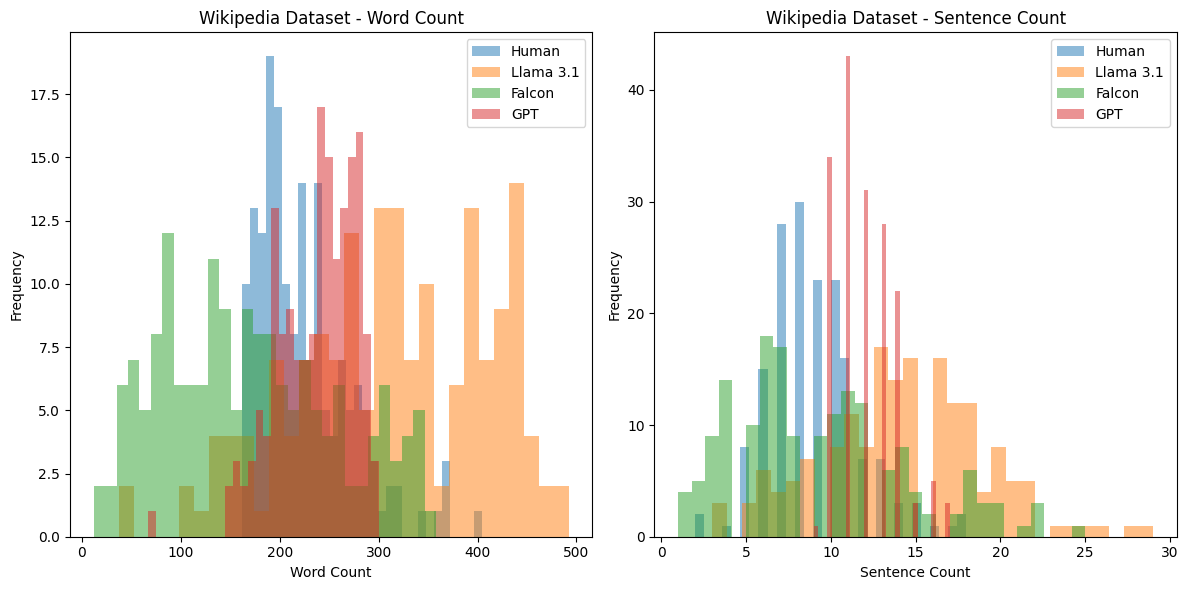


--- News Dataset Analysis ---
Metric              Human               GPT                 Llama 3.1           Falcon              
Min                 (283, 9)            (293, 13)           (95, 4)             (40, 2)             
Max                 (596, 49)           (630, 27)           (956, 47)           (722, 53)           
Avg                 (469.741, 23.124)   (443.924, 18.482)   (385.871, 17.753)   (286.888, 15.188)   
Median              (473.0, 22.0)       (444.0, 18.0)       (361.5, 16.0)       (248.0, 13.0)       
avg_word_diff       -                   -25.818,-4.759%     -83.871,-17.006%    -182.853,-38.479%   
avg_sentence_diff   -                   -4.641,-14.348%     -5.371,-18.286%     -7.935,-31.493%     


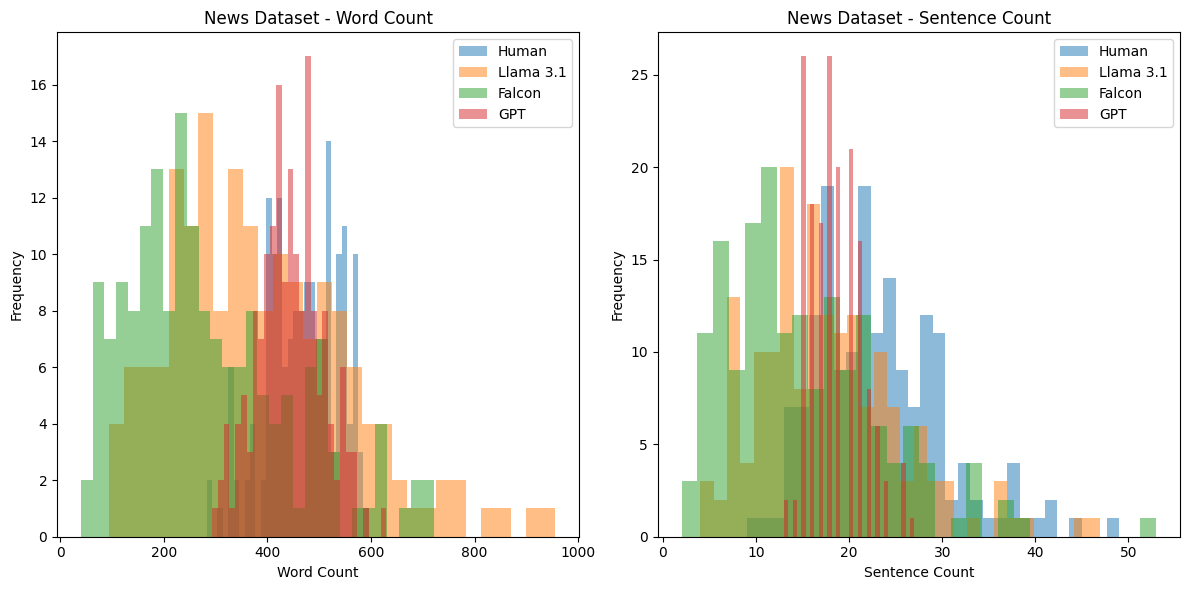


--- Abstracts Dataset Analysis ---
Metric              Human               GPT                 Llama 3.1           Falcon              
Min                 (176, 6)            (238, 10)           (85, 1)             (31, 1)             
Max                 (851, 35)           (516, 22)           (622, 52)           (411, 25)           
Avg                 (519.171, 17.624)   (368.524, 14.582)   (276.471, 11.541)   (182.665, 8.029)    
Median              (502.5, 17.0)       (378.5, 14.0)       (261.0, 10.5)       (169.5, 7.0)        
avg_word_diff       -                   -150.647,-26.888%   -242.7,-45.394%     -336.506,-63.965%   
avg_sentence_diff   -                   -3.041,-7.56%       -6.082,-29.701%     -9.594,-51.327%     


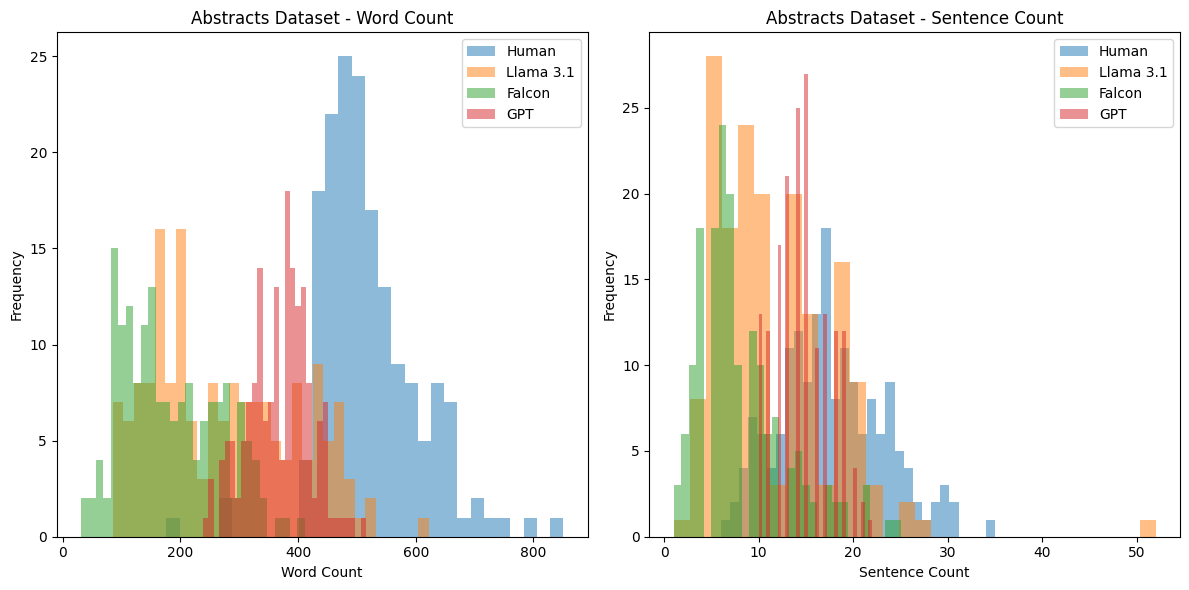

In [68]:
# Load cleaned datasets
wiki_clean = pd.read_csv("src/wiki_dataset_clean.csv")
news_clean = pd.read_csv("src/news_dataset_clean.csv")
abstracts_clean = pd.read_csv("src/abstracts_dataset_clean.csv")

# Analyze lengths for each dataset
analyze_lengths("Wikipedia Dataset", wiki_clean)
analyze_lengths("News Dataset", news_clean)
analyze_lengths("Abstracts Dataset", abstracts_clean)

In [75]:
def debug_flagged_rows(df, models, percentile=5):
    """
    Fixes and debugs the flagging of rows with extreme lengths.
    Adds the `bad_length` column with the correct model names.
    """
    df['bad_length'] = None  # Initialize the column

    # Safely parse human lengths
    human_lengths = np.array(
        df['human_len'].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
    )

    for model in models:
        # Safely parse model lengths
        generated_lengths = np.array(
            df[model].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
        )
        word_diff = generated_lengths[:, 0] - human_lengths[:, 0]  # Word count difference

        # Calculate thresholds
        low_threshold = np.percentile(word_diff, percentile)
        high_threshold = np.percentile(word_diff, 100 - percentile)

        # Debugging: Output thresholds
        print(f"Model: {model}")
        print(f"  Low Threshold: {low_threshold}")
        print(f"  High Threshold: {high_threshold}")

        # Identify rows with extreme word differences
        extreme_mask = (word_diff < low_threshold) | (word_diff > high_threshold)
        flagged_indices = np.where(extreme_mask)[0]

        # Debugging: Output indices and differences
        print(f"  Flagged Indices: {flagged_indices}")
        for idx in flagged_indices:
            print(f"    Row {idx}: Human Words = {human_lengths[idx, 0]}, "
                  f"Model Words = {generated_lengths[idx, 0]}, Difference = {word_diff[idx]}")

        # Update bad_length column
        df.loc[extreme_mask, 'bad_length'] = df.loc[extreme_mask, 'bad_length'].fillna('') + model.replace('_len', '') + '; '

    # Clean up trailing semicolons
    df['bad_length'] = df['bad_length'].str.strip('; ')

    # Output final flagged rows for verification
    flagged_rows = df[df['bad_length'].notnull()]
    print("\nFinal Flagged Rows:")
    print(flagged_rows[['human_len', *models, 'bad_length']])
    return df


In [76]:
models_to_check = ['gpt_len', 'Llama3.1_clean_len', 'Falcon_clean_len']
# Apply debugging to flagged rows
debugged_df = debug_flagged_rows(df, models_to_check)


Model: gpt_len
  Low Threshold: -307.15
  High Threshold: -23.600000000000136
  Flagged Indices: [  2   3   8  11  31  34  74  80  97 101 104 123 129 139 145 151 163 165]
    Row 2: Human Words = 274, Model Words = 378, Difference = 104
    Row 3: Human Words = 798, Model Words = 418, Difference = -380
    Row 8: Human Words = 694, Model Words = 338, Difference = -356
    Row 11: Human Words = 851, Model Words = 337, Difference = -514
    Row 31: Human Words = 645, Model Words = 291, Difference = -354
    Row 34: Human Words = 757, Model Words = 399, Difference = -358
    Row 74: Human Words = 704, Model Words = 238, Difference = -466
    Row 80: Human Words = 479, Model Words = 488, Difference = 9
    Row 97: Human Words = 176, Model Words = 370, Difference = 194
    Row 101: Human Words = 449, Model Words = 435, Difference = -14
    Row 104: Human Words = 472, Model Words = 452, Difference = -20
    Row 123: Human Words = 452, Model Words = 435, Difference = -17
    Row 129: Human Wo